# Predict the stock market

In [1]:
# Set un the environment
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
from pandas import Series, datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns

/Users/clairemalbrel/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


## Preprocessing

In [2]:
df_news = pd.read_csv("/Users/clairemalbrel/code/clairemalbrel/STOCK_PREDICT/data/combined_stock_data.csv")
df_djia = pd.read_csv("/Users/clairemalbrel/code/clairemalbrel/STOCK_PREDICT/data/DJIA_table.csv")

In [3]:
df_news['Date'] = pd.to_datetime(df_news['Date'])
df_djia['Date'] = pd.to_datetime(df_djia['Date'])

In [4]:
df = df_news[['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive','Negative', 'Neutral']].merge(df_djia)

In [5]:
def categorical(x):
    if x > 0:
        x = 1
    else:
        x = 0
    return x

df['change'] = df['Open'].pct_change()
# remove first row
df['change'] = df['change'].shift(-1)
df['target'] = df['change'].apply(categorical)

In [6]:
df.index = df.index.sort_values()

In [7]:
df.head()

,Date,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,change,target
0,2008-08-08,0,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,-0.244438,0
1,2008-12-08,0,56.250000,43.750000,18.750000,37.500000,43.750000,8637.650391,9026.410156,8637.490234,8934.179688,358970000,8934.179688,0.346756,1
2,2008-08-13,0,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,-0.008660,0
3,2008-08-14,1,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,0.006863,1
4,2008-08-15,1,70.000000,30.000000,10.000000,60.000000,30.000000,11611.209961,11709.889648,11599.730469,11659.900391,215040000,11659.900391,0.004172,1


## Heatmap of features

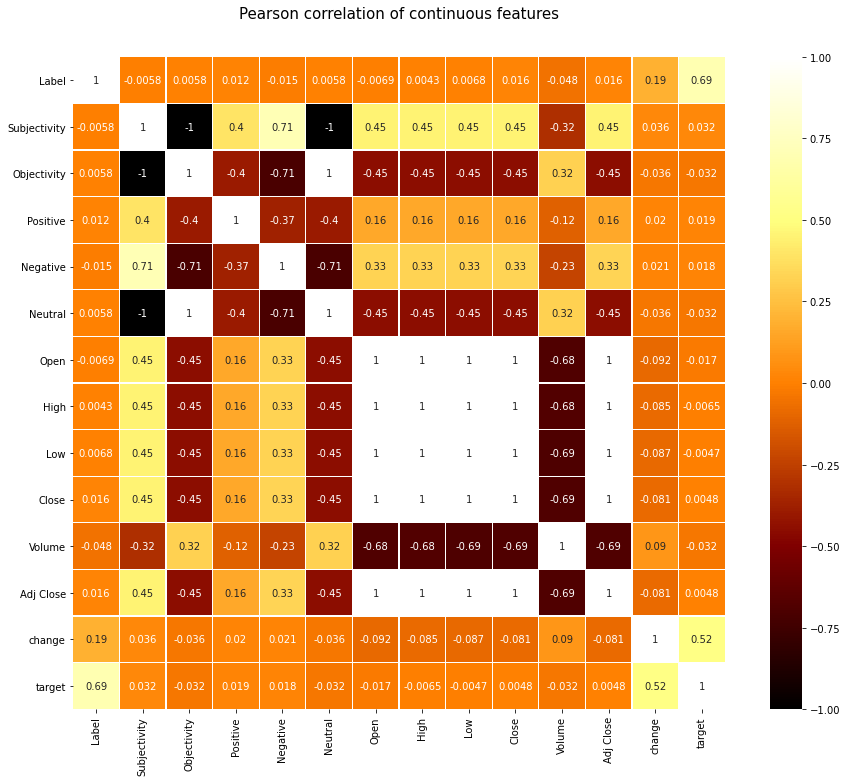

In [8]:
colormap = pyplot.cm.afmhot
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

## Preprocessing and cleaning

In [9]:
df = df.dropna()
df.isnull().sum()

Date            0
Label           0
Subjectivity    0
Objectivity     0
Positive        0
Negative        0
Neutral         0
Open            0
High            0
Low             0
Close           0
Volume          0
Adj Close       0
change          0
target          0
dtype: int64

In [10]:
y = df['target']

In [11]:
X = df.drop('Label', axis = 1)
X = X.drop('target', axis = 1)
X = X.drop('Date', axis = 1)
X = X.drop('change', axis = 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

## Modelling

In [14]:
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_lda.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))

accuracy score:
0.7982456140350878


## TPOT

In [17]:
from sklearn.model_selection import train_test_split
import os
from tpot import TPOTClassifier

rescaledValidationX = scaler.transform(X_test)

# instanciate TPOTClassifier
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, n_jobs=-1)
# process autoML with TPOT
tpot.fit(rescaledX, y_train)
# print score
print(tpot.score(rescaledValidationX, y_test))
tpot.export('tpot_stock_pipeline.py')


Generation 1 - Current best internal CV score: 0.8018771458426631
Generation 2 - Current best internal CV score: 0.8018771458426631
Generation 3 - Current best internal CV score: 0.8036087475742647
Generation 4 - Current best internal CV score: 0.8053291536050157
Generation 5 - Current best internal CV score: 0.8053291536050157
Best pipeline: XGBClassifier(PCA(input_matrix, iterated_power=9, svd_solver=randomized), learning_rate=0.1, max_depth=2, min_child_weight=17, n_estimators=100, nthread=1, subsample=1.0)
0.8052631578947368


In [19]:
from sklearn.model_selection import train_test_split
import os
from tpot import TPOTClassifier

# instanciate TPOTClassifier
rescaledValidationX = scaler.transform(X_test)

tpot = TPOTClassifier(verbosity=3, scoring='accuracy', random_state=32,  n_jobs=-1, generations=5, population_size=100)

# process autoML with TPOT
tpot.fit(rescaledX, y_train)
# print score
print(tpot.score(rescaledValidationX, y_test))
tpot.export('tpot_stock_pipeline.py')

32 operators have been imported by TPOT.


_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _random_mutation_operator: num_test=0 Negative values in data passed to MultinomialNB (input X).
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 58.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 73.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 Negative values in data passed to MultinomialNB (input X).
_pre_test decorator: _random_mu

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 4 - Current Pareto front scores:
-1	0.7845872518286312	LinearSVC(input_matrix, LinearSVC__C=20.0, LinearSVC__dual=True, LinearSVC__loss=hinge, LinearSVC__penalty=l2, LinearSVC__tol=0.0001)
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Paramete